The NBA playoffs are coming soon and the brackets are almost set. This notebook aims determine the probability of a team making the playoffs based on stats recorded in a single game.

This granular approach allows for sequence modelling: estimating the probability of a team making the playoffs given their stats recorded over a span of games e.g. 10,15,30 games?

This project delivers value by:
- revealing indicators of success that tend to appear in the NBA
- providing a measure of a team's performance given their goal of making the playoffs

In [1]:
import sqlalchemy
from os import environ

import numpy as np
import pandas as pd

The data used in this projects are the traditional team box scores during the regular and postseasons from the 1989-90 to 2020-21. These box scores represent the team's sum (in the case of percentages, the total percentages) of each statistic in a game.

Data was sourced from the NBA's official website: https://www.nba.com/stats/teams/boxscores/

The data is stored locally in a MySQL database and is imported as follows:

In [2]:
engine = sqlalchemy.create_engine("mariadb+mariadbconnector://"+environ.get("USER")+\
                                  ":"+environ.get("PSWD")+"@127.0.0.1:3306/nba")

In [3]:
command = "SELECT Teams.Name AS Team, Team_box_scores.* FROM Team_box_scores"+\
" INNER JOIN Teams ON Team_box_scores.Team_ID = Teams.ID "

df = pd.read_sql(command,engine,parse_dates='Game_day')

In [4]:
drop_columns = ['Team_ID']
df.drop(columns=drop_columns,inplace = True)

In [5]:
def made_playoffs(df):
    # Season_type will be used to differentiate regular season from playoffs.
    true = 1
    false = 0
    
    df["Season_type"] = df["Game_ID"].str.slice(0,3) # first three digits represent the season type
    df["Year"] = df["Game_ID"].str.slice(3,5) # 4th and 5th digit represent year the season started
    df['Playoffs'] = true
    
    # gdf.index is a tuple of size 3 of the format: (Team, season_type, year)
    gdf = df.groupby(['Team','Season_type','Year']).count()

    # Change Playoffs variable to False if there is no playoff data for that team that year.
    for t,s,y in gdf.index:
        if(s=='004'):
            l = gdf.loc[t].loc[s].index
            df.loc[df['Team']==t,"Playoffs"] = df.loc[df['Team']==t,"Playoffs"].where(df["Year"].isin(l),false)

    # Now that the playoff status has been established, the temporary variables can be removed
#     df = df[df['Season_type']=='002']
    
    df.drop(index=df[df['Season_type']=='004'].index,inplace=True)
    drop_cols = ['Season_type','Year']
    df.drop(columns = drop_cols,inplace=True)
    
    return df

In [6]:
df = made_playoffs(df)

# Basic exploration

The data is relatively clean with 103 null values for the variable P3P (3P%) which means that there were 103 games over the last 33 years in which a team did not attempt 3 point shots. The null value is a result of dividing FGM by FGA which are both 0. As a result, in this case null and 0 are semantically the same thing: that no 3 point shots were made. So the null values can be can be replaced by 0. The same can be done for incoming FGP, FTP. This will be implemented in the data cleaning portion of this analysis.

In [7]:
df.shape

(74454, 25)

In [8]:
df.isna().sum()

Team          0
Game_ID       0
Matchup       0
Game_day      0
Result        0
MINS          0
PTS           0
FGM           0
FGA           0
FGP           0
PM3           0
PA3           0
P3P         103
FTM           0
FTA           0
FTP           0
OREB          0
DREB          0
REB           0
AST           0
TOV           0
STL           0
BLK           0
PF            0
Playoffs      0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74454 entries, 0 to 79503
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Team      74454 non-null  object        
 1   Game_ID   74454 non-null  object        
 2   Matchup   74454 non-null  object        
 3   Game_day  74454 non-null  datetime64[ns]
 4   Result    74454 non-null  object        
 5   MINS      74454 non-null  int64         
 6   PTS       74454 non-null  int64         
 7   FGM       74454 non-null  int64         
 8   FGA       74454 non-null  int64         
 9   FGP       74454 non-null  float64       
 10  PM3       74454 non-null  int64         
 11  PA3       74454 non-null  int64         
 12  P3P       74351 non-null  float64       
 13  FTM       74454 non-null  int64         
 14  FTA       74454 non-null  int64         
 15  FTP       74454 non-null  float64       
 16  OREB      74454 non-null  int64         
 17  DREB      74

Below is the histogram for each numeric variable

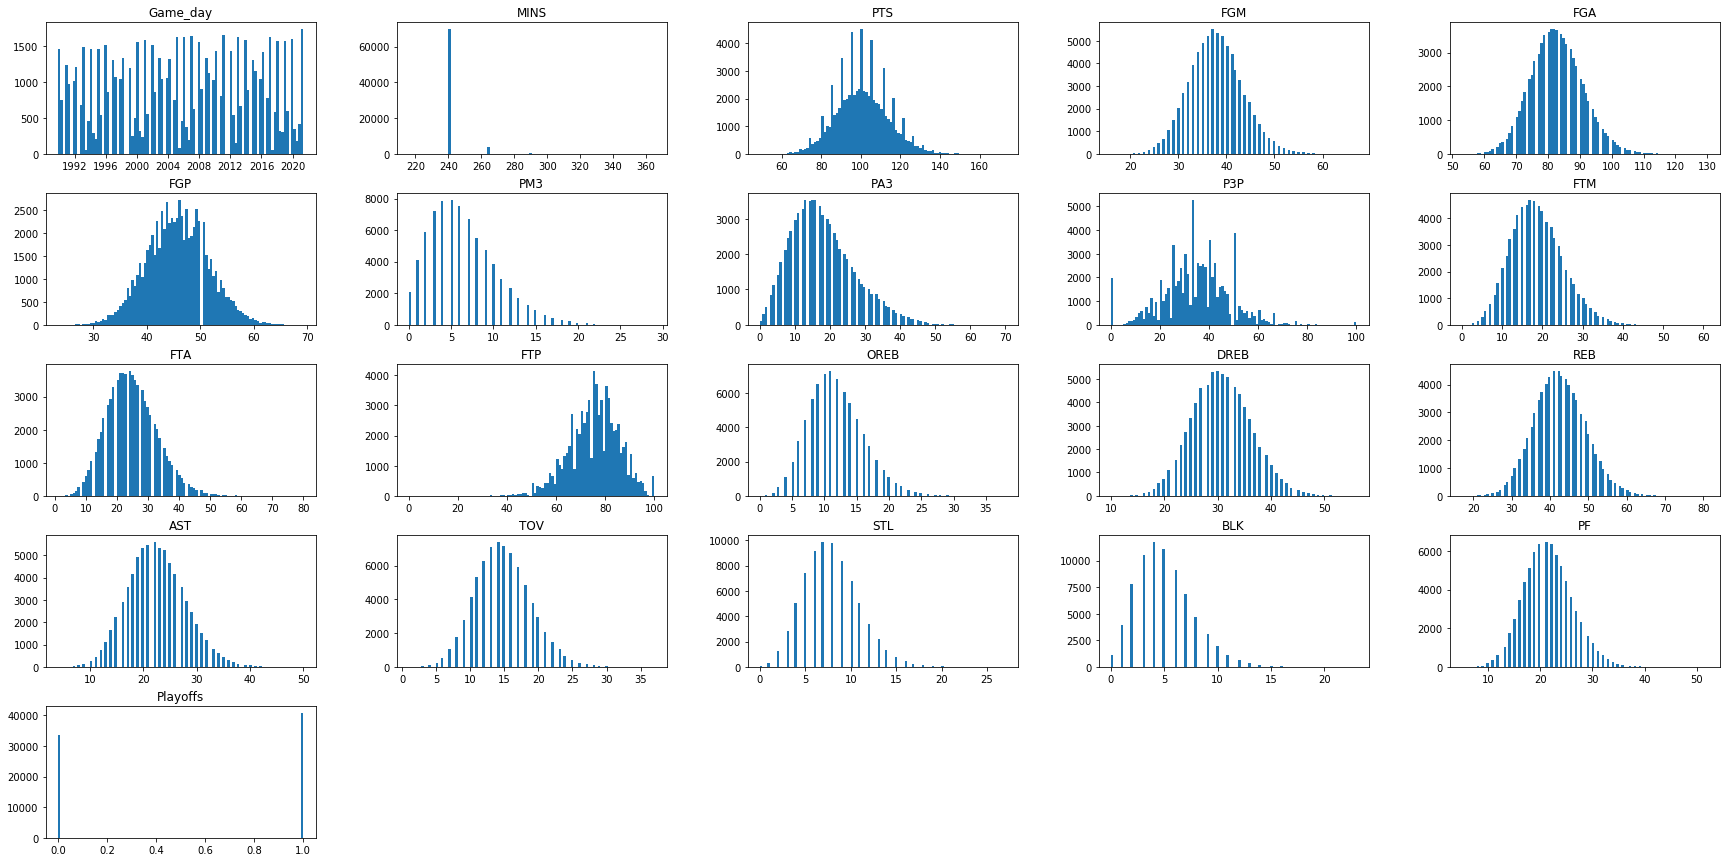

In [12]:
import matplotlib.pyplot as plt
% matplotlib inline
df.hist(bins = 100,figsize=(30,15),grid=False)
plt.show()

### Observations:

With the exception of the Minutes played, all other numeric statistics are roughly normally distributed. This pattern is typical throughout basketball (from team performance to individual performance) and it is this property that that will be useful for a number of machine learning methods.

Minutes played will not follow a normal distribution because most games typically end in regulation and increasingly less every subsequent overtime period. This distribution is unlikely to be informative as a predictor to make the playoffs.

It must be noted that the PM3 (3PM) and PA3 (3PA) variables are right skewed. This indicates that historically, teams did not typically attempt or make 3 point shots. With the rise in popularity of the 3 point shot in recent years, I suspect that these distributions are likely to become more centred and resemble a normal distribution. A dashboard showing these histograms bound in time will reveal this change if it exists. 

The Game_day variable shows a cyclical pattern to the NBA season.

# Test set allocation
Best practice dictates that a test set must now be created and remain unseen the until models are tested.

Since there are a large number of records $\approx$ 75K, the data can be randomly sampled. The test size will be 20% of the data collected and will be used to evaluate the final model. For reprducability, the random seed will be 10.

Model selection will be done using cross-validation.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
features = ['Result', 'MINS', 'PTS', 'FGM', 'FGA', 'FGP', 'PM3', 'PA3', 'P3P','FTM','FTA',
              'FTP', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK','PF']
dependent = ['Playoffs']

In [15]:
def split_train_test(df, SEED = 10, test_size=0.2):
    train,test = train_test_split(df,random_state=SEED,test_size=test_size)
    
    return train, test

In [16]:
train, test = split_train_test(df)

# Exploratory analysis

First, let's explore the correlations between the variables. One of the assumptions for logistic regression is that predictor variables must be independent of each other. It will be important to exclude the strongly correlated variables from the the input features.

In [17]:
corr_matrix = train.corr()

In [18]:
def plot_correlation_matrix(corr_matrix):
    precision = 2
    cmap = 'seismic' #'coolwarm'
    
    return corr_matrix.style.background_gradient(cmap=cmap,vmin=-1,vmax=1).format(precision=precision)

In [19]:
plot_correlation_matrix(corr_matrix)

,MINS,PTS,FGM,FGA,FGP,PM3,PA3,P3P,FTM,FTA,FTP,OREB,DREB,REB,AST,TOV,STL,BLK,PF,Playoffs
MINS,1.00,0.19,0.15,0.27,-0.04,0.05,0.06,0.00,0.10,0.11,0.00,0.08,0.16,0.19,0.07,0.07,0.03,0.06,0.17,0.00
PTS,0.19,1.00,0.85,0.40,0.68,0.42,0.26,0.34,0.32,0.27,0.19,-0.00,0.21,0.17,0.59,-0.12,0.12,0.06,0.10,0.12
FGM,0.15,0.85,1.00,0.54,0.74,0.23,0.10,0.24,-0.14,-0.15,0.01,0.04,0.16,0.16,0.67,-0.14,0.12,0.06,0.02,0.08
FGA,0.27,0.40,0.54,1.00,-0.16,0.15,0.24,-0.09,-0.21,-0.22,-0.01,0.49,0.18,0.46,0.26,-0.25,0.14,0.03,0.03,-0.05
FGP,-0.04,0.68,0.74,-0.16,1.00,0.16,-0.07,0.35,0.01,-0.00,0.02,-0.33,0.04,-0.18,0.57,0.04,0.03,0.05,0.00,0.13
PM3,0.05,0.42,0.23,0.15,0.16,1.00,0.86,0.52,-0.16,-0.19,0.05,-0.24,0.21,0.03,0.24,-0.09,-0.06,-0.04,-0.11,0.06
PA3,0.06,0.26,0.10,0.24,-0.07,0.86,1.00,0.11,-0.17,-0.20,0.05,-0.18,0.25,0.09,0.09,-0.11,-0.06,-0.05,-0.13,0.04
P3P,0.00,0.34,0.24,-0.09,0.35,0.52,0.11,1.00,-0.04,-0.05,0.03,-0.17,0.03,-0.08,0.26,-0.01,-0.02,0.01,-0.01,0.05
FTM,0.10,0.32,-0.14,-0.21,0.01,-0.16,-0.17,-0.04,1.00,0.93,0.34,0.06,0.02,0.06,-0.09,0.05,0.07,0.05,0.23,0.06
FTA,0.11,0.27,-0.15,-0.22,-0.00,-0.19,-0.20,-0.05,0.93,1.00,-0.02,0.11,0.01,0.08,-0.11,0.07,0.09,0.06,0.25,0.05


It can be seen that there are a number of positive correlations, most of them regarding the scoring aspect of the game such as field goals, points, assists and free throws. There are a few negatively correlated relationships but they appear to be weak.

It is worth making the Result column boolean of whether the team won or not. There is an obvious order: winning being more desirable than losing. This can be encoded as: 1 for a win and 0 for a loss.

In [20]:
def make_boolean(df,true_value, column):
    df[column] = df[column]==true_val
    
    return df

There is a suggestion a home court advantage exists in the NBA. However, research indicates that it is not statistically significant. Keeping this in mind, it could also be useful to include a binary field, "Home" where 1 is a game played at home and 0 is a game played away.

During model selection, it would pay to see how well the model does with and without this variable.

In [21]:
def include_home(df):
    indicator_col = 'Matchup'
    # if Matchup record contains '@', game is away. Else game is home.
    ind = df[indicator_col].str.contains('@')
    df['Home'] = 0
    df['Home'].where(ind,1,inplace=True)
    
    return df

Since teams are ranked within their conference, it could be useful to include the conference a team competes in. If there are any significant diifferences between the conferences, this difference would not be relevant to predict teams in different conferences making the playoffs but could be useful in determining the odds of the NBA finals in which the two conferences converge.

So the function below creates a new column called 'Conference' that indicates the conference the team belongs to. This variable could be useful to determine whether, on average one conference is 'stronger' than the other.

In [28]:
def include_conference(df):
    west = ['NOP','UTA', 'MEM','PHX', 'POR', 'SAC', 'SAS', 'OKC','DAL', 'DEN', 'GSW', 'HOU','LAC', 'LAL','MIN']
    
    df['Conference'] = 'West'
    df['Conference'].where(df['Team'].isin(west),'East',inplace=True)
    
    return df

In [29]:
train.columns

Index(['Team', 'Game_ID', 'Matchup', 'Game_day', 'Result', 'MINS', 'PTS',
       'FGM', 'FGA', 'FGP', 'PM3', 'PA3', 'P3P', 'FTM', 'FTA', 'FTP', 'OREB',
       'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'Playoffs', 'Poss',
       'PPP', 'OREB%', 'ATR', 'FTR', 'eFG', 'Conference', 'Home'],
      dtype='object')

There are a few statitics that can be derived with traditional box score stats including possessions (Poss), points per possession (PPP), offensive rebound percentage (OREB%), free throw rate (FTR), assist-turnover ratio (ATR) and effective field goal percentage (eFG).

In [30]:
def add_new_features(df):
    df["Poss"] = df["FGA"] - df["TOV"] + df["OREB"] + 0.44*df["FTA"]
    df["PPP"] = df["PTS"]/df["Poss"]
    df['OREB%'] = df["OREB"]/(df["FGA"] -df["FGM"])
    df['ATR'] = df["AST"]/df["TOV"]
    df['FTR'] = df["FTA"]/df["FGA"]
    df['eFG'] = 100*(df['FGM']+.5*df['PM3'])/df['FGA']
    
    df = include_conference(df)
    df = include_home(df)
    
    return df

In [31]:
train = add_new_features(train)

In [32]:
train.head()

,Team,Game_ID,Matchup,Game_day,Result,MINS,PTS,FGM,FGA,FGP,...,PF,Playoffs,Poss,PPP,OREB%,ATR,FTR,eFG,Conference,Home
62206,OKC,0029300257,SEA vs. ORL,1993-12-14,W,240,124,51,92,55.4,...,22,1,99.56,1.245480,0.341463,1.941176,0.260870,57.608696,West,1
3978,BOS,0020401217,BOS vs. NJN,2005-04-20,L,240,93,35,76,46.1,...,33,1,75.48,1.232114,0.268293,1.263158,0.223684,52.631579,East,1
71544,MEM,0022000607,MEM @ PHX,2021-03-15,L,240,99,38,87,43.7,...,17,1,97.44,1.016010,0.204082,1.363636,0.298851,46.551724,West,0
25431,LAC,0021300472,LAC vs. CHA,2014-01-01,W,240,112,47,85,55.3,...,20,1,82.40,1.359223,0.210526,2.400000,0.117647,61.764706,West,1
59983,SAS,0020100547,SAS vs. UTA,2002-01-17,W,240,102,34,75,45.3,...,20,1,90.08,1.132327,0.268293,1.400000,0.426667,48.000000,West,1


In [36]:
idx = ['Poss',"PPP",'OREB%','ATR','FTR','eFG']

In [37]:
corr_matrix = train.corr()
plot_correlation_matrix(corr_matrix.loc[idx,idx])

,Poss,PPP,OREB%,ATR,FTR,eFG
Poss,1.00,-0.58,0.44,0.40,-0.10,-0.25
PPP,-0.58,1.00,-0.31,-0.02,0.21,0.86
OREB%,0.44,-0.31,1.00,-0.09,0.13,-0.10
ATR,0.40,-0.02,-0.09,1.00,-0.18,0.30
FTR,-0.10,0.21,0.13,-0.18,1.00,-0.01
eFG,-0.25,0.86,-0.10,0.30,-0.01,1.00


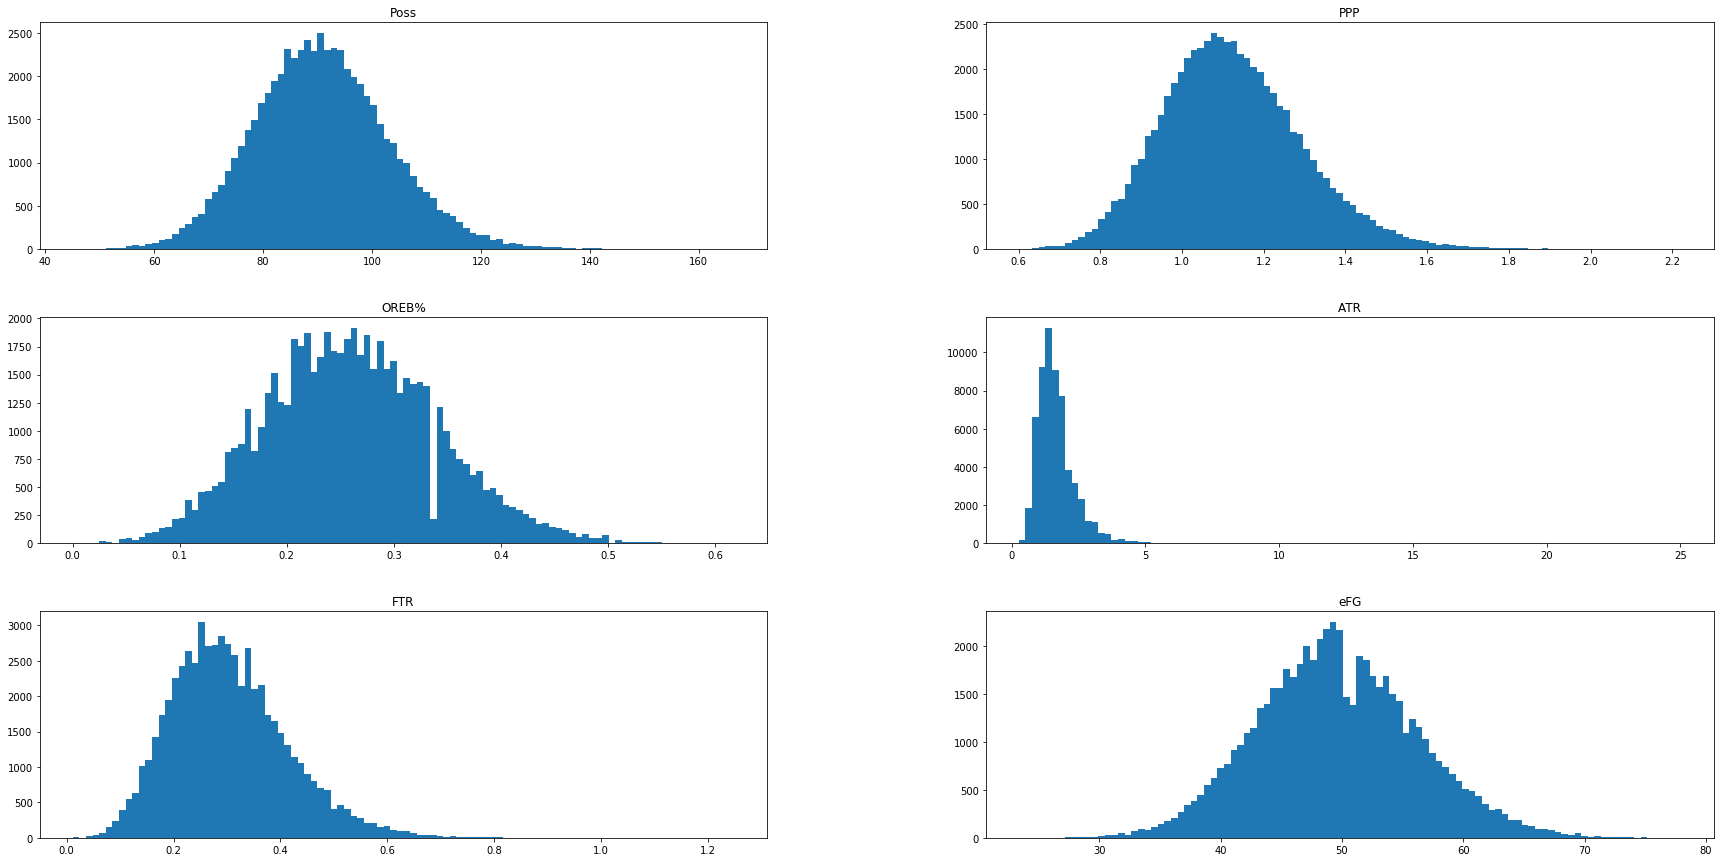

In [38]:
train[idx].hist(bins=100,figsize=(30,15),grid=False)
plt.show()

## Observations

The derived stats are mostly normally distributed with the exception of the assist to the turnover ratio (ATR). A log transformation may make this distribution normal. Since the range is very limited, a base $log_2$ transformation will limit the "squashing" of range. 

In [39]:
log_ART = np.log2(train['ATR'])

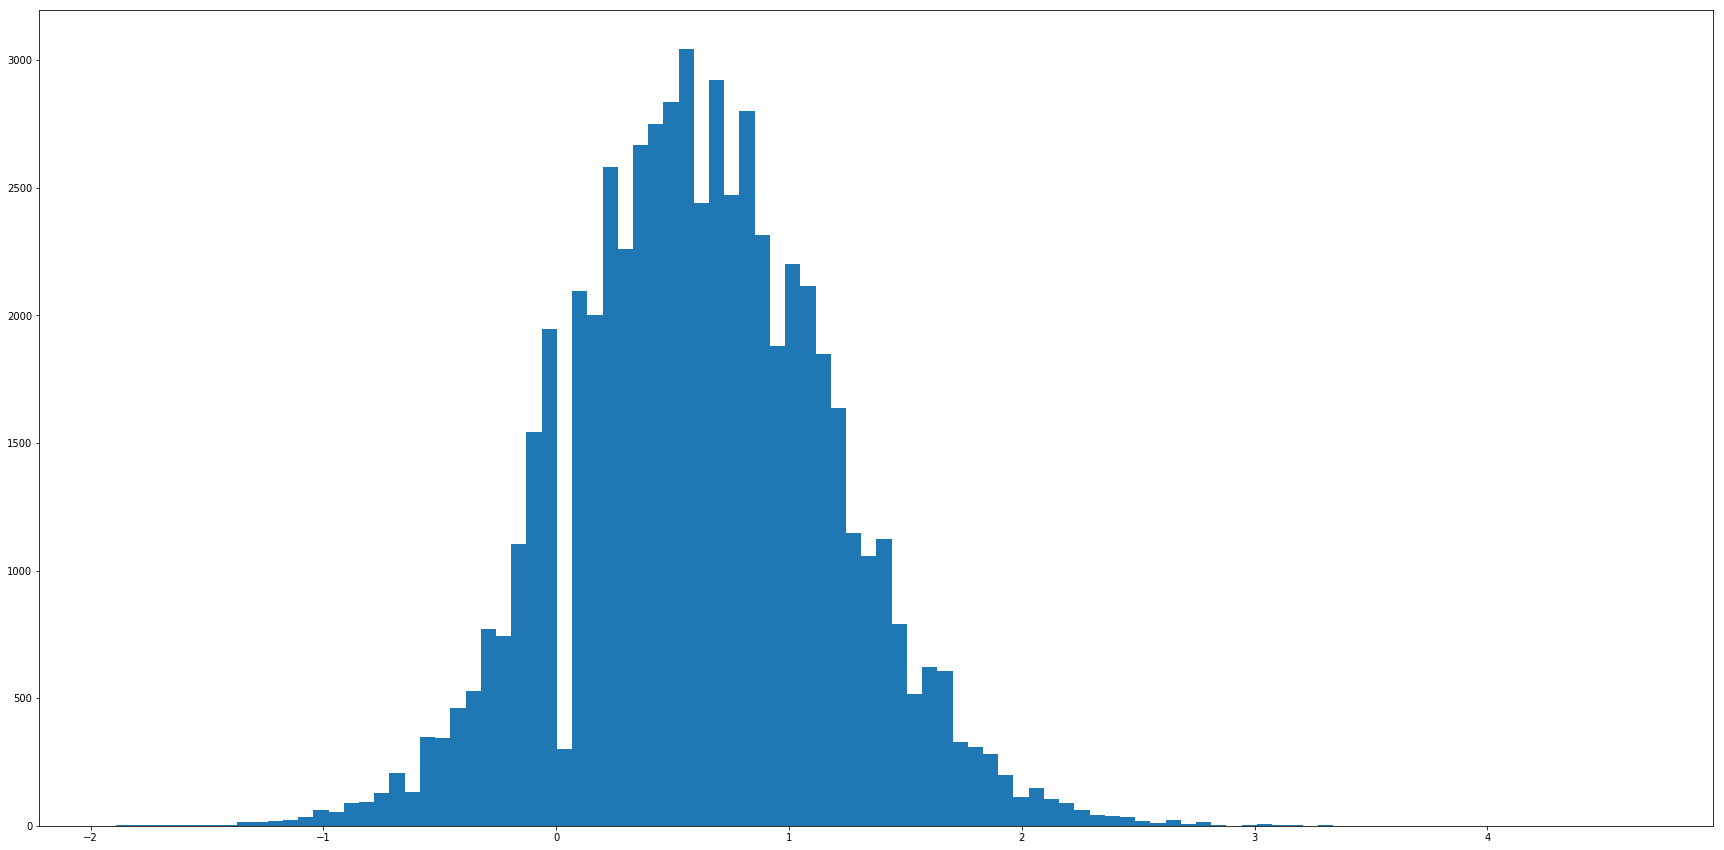

In [40]:
log_ART.hist(bins = 100,figsize=(30,15),grid=False)

### Observation

The $log_2$ transformation of ART is a normal distribution. This transformation is suitable for the variable.

## Data cleaning

The data is relatively clean as a result of rigorous data collection by the NBA. Exceptions of missing data are as a result of dividing by zero. The cleaning scheme will be as follows:

- Shooting percentage (FG%,FT%,3P%) can reasonably be replaced with 0 is the record is nan 
- If there are other missing values in the fields other than shooting percentage fields, it is likely a an error either in the local database (there was an error writing to the database) or the error is on the NBA's records. For the sake of this analysis, the record will be dropped

In [32]:
def clean(df):
    percentage_fields = ['FGA','FTA','P3P']
    vals = {i:0 for i in percentage_fields}

    df.fillna(value=vals,inplace=True)

    return df.dropna()

In [33]:
train = clean(train)

In [62]:
train.columns

Index(['Team', 'Game_ID', 'Matchup', 'Game_day', 'Result', 'MINS', 'PTS',
       'FGM', 'FGA', 'FGP', 'PM3', 'PA3', 'P3P', 'FTM', 'FTA', 'FTP', 'OREB',
       'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'Playoffs', 'Home',
       'Poss', 'PPP', 'OREB%', 'ATR', 'FTR', 'eFG', 'Conference'],
      dtype='object')

## Data transformation and scaling

The following transformation will be applied to the following variables:
- $log_2$ transformation on assist-turnover ratio (ATR)
- map Results column to binary variable. W --> 1 and L --> 0
- one-hot encode the Conference variable

$\textbf{Note:}$ It may be useful to consider a model in which shooting attempts like FGA and 3PA are squared because there is a tradeoff between taking more shots and taking less shots. Given that average FG% and 3P% are below $50\%$, attempts from the field are more likely to miss than not, meaning that after a point, it actually hurts a team to keep attempting to score from the field. Too few shots mean the team does not realise the number of shots they can make. 

### Scaling
The numeric variables (with the inclusion of transformed variables) are normally distributed, making them suitable for standard scaling.  